# Advanced SVD Methods
This notebook explores some advanced versions of the Singular Value Decomposition (SVD) technique, in particular: the Hierarchical SVD (hSVD) [Iwen and Ong. (2016)](https://epubs.siam.org/doi/10.1137/16M1058467) and the Incremental SVD (iSVD) [TBD](...).

These methods are particularly useful for parametric PDEs, where the solution depends on multiple parameters and traditional SVD methods may become computationally expensive especially in terms of memory usage.

In this notebook, we will consider a parametric flow over cylinder problem, from CFDBench [Luo et al. (2024)](https://arxiv.org/abs/2310.05963): the inlet boundary is parametrized with respect to its intensity, from 0.1 m/s to 1.0 m/s.

At first, let us load the raw snapshots, downloaded from [the benchmark](https://huggingface.co/datasets/chen-yingfa/CFDBench/blob/main/cylinder/bc.zip) - the zenodo folder only contains the first 10 parameters, instead of the full 50.

In [1]:
import numpy as np
import os
from IPython.display import clear_output

folder_to_save = '../Datasets/CFDBenchFlowCyl'

id_cases = [f for f in os.listdir(folder_to_save+'/') if os.path.isdir(os.path.join(folder_to_save+'/', f))]
id_cases.sort()

snap_data = list()
for case_i in range(1, len(id_cases)):
    snap_data.append(dict())

    snap_data[case_i-1]['u'] = np.load(folder_to_save + '/' + id_cases[case_i] + '/u.npy')
    snap_data[case_i-1]['v'] = np.load(folder_to_save + '/' + id_cases[case_i] + '/v.npy')

Nt, Nhx, Nhy = snap_data[0]['u'].shape
Ns = len(snap_data)

var_names = ['u', 'v']

print(f'Number of snapshots: {Ns}, Number of time steps: {Nt}, Grid size: {Nhx} x {Nhy}')

Number of snapshots: 10, Number of time steps: 1000, Grid size: 64 x 64


From the benchmark description, the geometry is generated in the pyvista format.

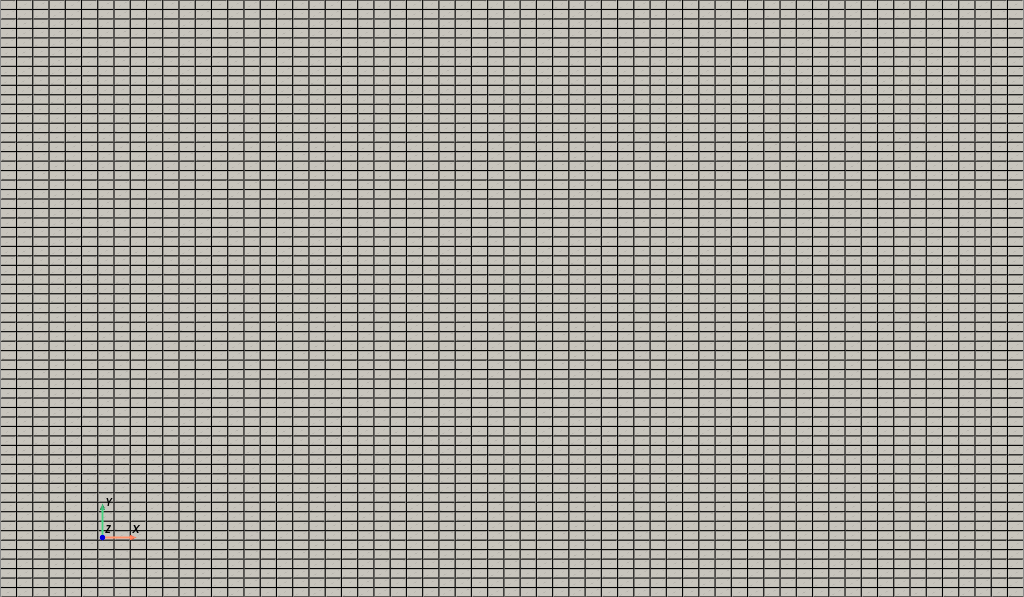

In [2]:
radius = 0.01
length = 0.16 + 0.06 + 2*radius
height = 2 * 0.06 + 2*radius

import pyvista as pv

x = np.linspace(0, length, Nhx)
y = np.linspace(0, height, Nhy)
X, Y = np.meshgrid(x, y, indexing="ij")
points = np.c_[X.ravel(), Y.ravel(), np.zeros_like(X.ravel())]

# --- Build connectivity for quadrilateral cells ---
# Each quad has 4 vertices, and we store them in the format:
# [4, id0, id1, id2, id3] for each cell
cells = []
for i in range(Nhx - 1):
    for j in range(Nhy - 1):
        p0 = i * Nhy + j
        p1 = p0 + 1
        p2 = p0 + Nhy + 1
        p3 = p0 + Nhy
        cells.append([4, p0, p1, p2, p3])

cells = np.array(cells, dtype=np.int64).ravel()

# Cell types: VTK_QUAD = 9
celltypes = np.full((Nhx - 1) * (Nhy - 1), 9, dtype=np.uint8)

# Plotting the grid
grid = pv.UnstructuredGrid(cells, celltypes, points)
plotter = pv.Plotter()
plotter.add_mesh(grid, show_edges=True, color='white', opacity=1)
plotter.view_xy()
plotter.camera.zoom('tight')
plotter.add_axes()
plotter.show(jupyter_backend='static')

nodes = grid.points[:, :2]  # Extract only x and y coordinates

The snapshots loaded before are the $x$ and $y$ components of the velocity field, parameterised with respect to the inlet velocity. We are going to store them in numpy arrays of the following shape $N_{params}\times N_t\times \mathcal{N}_h$, where $N_{params}$ is the number of parameters (inlet velocities), $N_t$ is the number of time steps, and $\mathcal{N}_h$ is the number of spatial degrees of freedom.

In [3]:
snapshots_np = {var_name: np.zeros((Ns, Nt, Nhx * Nhy)) for var_name in var_names}

for i in range(Ns):
    for var_name in var_names:
        for tt in range(Nt):
            snapshots_np[var_name][i, tt, :] = snap_data[i][var_name][tt].ravel(order='F')

Nh = Nhx * Nhy

from sklearn.model_selection import train_test_split
train_params, test_params = train_test_split(np.arange(Ns), test_size=0.2, random_state=7)

In the following, we will compare the modes, the singular values, the reconstruction errors and the computational times of the different SVD methods implemented in *pyforce*.

In [4]:
cpu_times = dict()

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

## Baseline: randomised SVD
In this section, we are going to compute the modes and the singular values adopting a monolithic approach, i.e., stacking all the snapshots in a single matrix and applying the randomised SVD algorithm from *pyforce*.

In [5]:
from pyforce.tools.functions_list import FunctionsList
snaps = {
    var_name: FunctionsList(snap_matrix = snapshots_np[var_name][train_params].reshape(-1, Nh).T) # Only training snapshots
    for var_name in var_names
}

from pyforce.offline.pod import rSVD
from time import process_time

rsvd = dict()
cpu_times['rSVD'] = []

rank = 100

for var_name in var_names:
    _start = process_time()
    rsvd[var_name] = rSVD(grid, gdim=2, varname=var_name)
    rsvd[var_name].fit(snaps[var_name], rank=rank)
    _end = process_time()
    cpu_times['rSVD'].append(_end - _start)

## Hierarchical SVD
The Hierarchical SVD (hSVD) is a method that updates the SVD modes and singular values in a hierachical manner: instead of stacking all the snapshots in a single matrix and perform the SVD, the snapshots are divided into parametric clusters and the SVD is performed on each cluster; then, the modes and singular values from each cluster are combined and a new SVD is performed on the combined modes.

In [8]:
snaps = dict()
for var_name in var_names:
    snaps[var_name] = list()
    for pp in train_params:
        snaps[var_name].append( FunctionsList(snap_matrix = snapshots_np[var_name][pp, :, :].T) )
            
from pyforce.offline.pod import HierarchicalSVD as hSVD
hsvd = dict()
cpu_times['hSVD'] = []

for var_name in var_names:
    _start = process_time()
    hsvd[var_name] = hSVD(grid, gdim=2, varname=var_name)

    # Fit on each parameter cluster
    for pp in range(len(train_params)):
        hsvd[var_name].update(train_snaps=snaps[var_name][pp], rank=rank)
    _end = process_time()
    cpu_times['hSVD'].append(_end - _start)

## Incremental SVD
The Incremental SVD (iSVD) is a method that updates the SVD modes and singular values incrementally: instead of stacking all the snapshots in a single matrix and perform the SVD, the snapshots are added one by one and the SVD is updated at each step.

In [9]:
snaps = dict()
for var_name in var_names:
    snaps[var_name] = list()
    for pp in train_params:
        snaps[var_name].append( FunctionsList(snap_matrix = snapshots_np[var_name][pp, :, :].T) )
            
from pyforce.offline.pod import IncrementalSVD as iSVD
isvd = dict()
cpu_times['iSVD'] = []

for var_name in var_names:
    _start = process_time()
    isvd[var_name] = iSVD(grid, gdim=2, varname=var_name)

    # Fit on each parameter cluster
    for pp in range(len(train_params)):
        if pp == 0:
            isvd[var_name].fit(train_snaps=snaps[var_name][pp], rank=rank)
        else:
            isvd[var_name].update(new_snap=snaps[var_name][pp])
    _end = process_time()
    cpu_times['iSVD'].append(_end - _start)

## Comparison of the methods
In this section, we are going to compare the modes, the singular values, the reconstruction errors and the computational times of the different SVD methods implemented in *pyforce*.

### Singular values


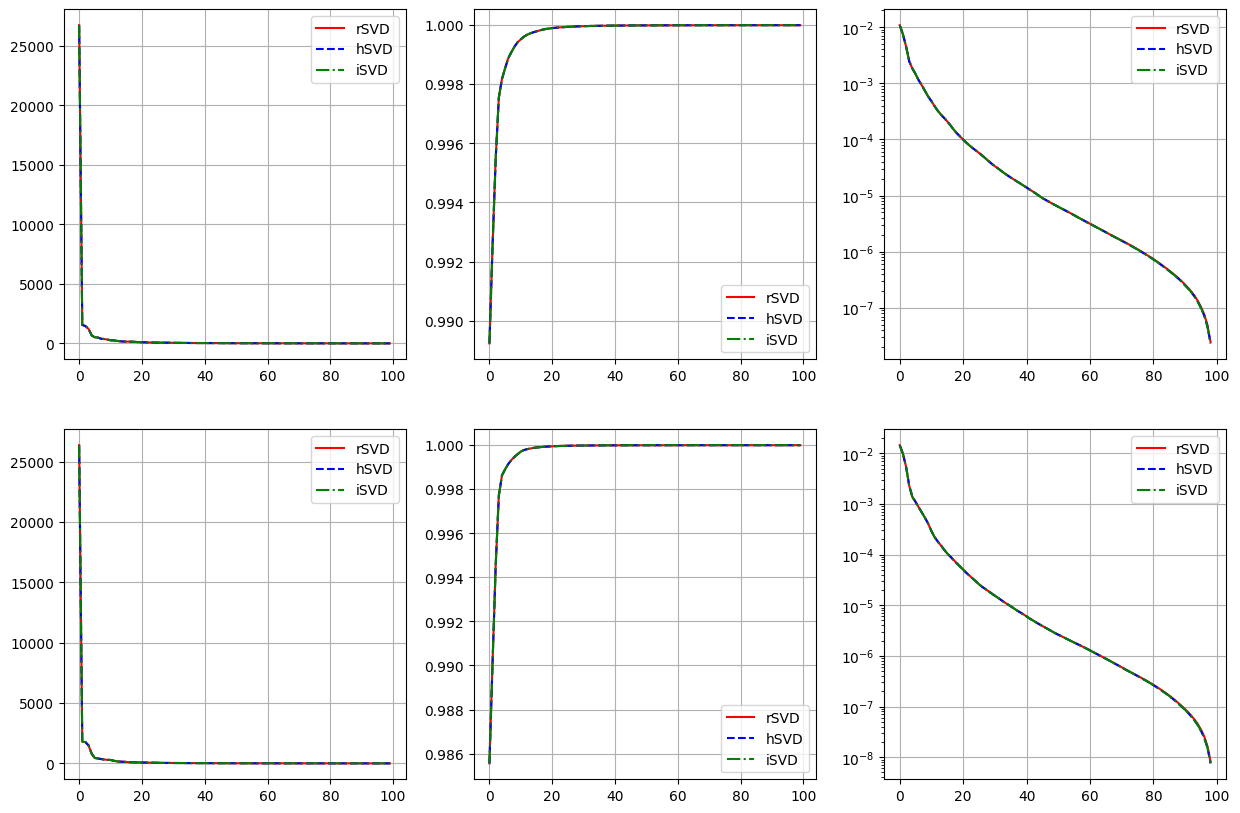

In [11]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(len(var_names), 3, figsize=(15, 5*len(var_names)))

for field_i, field in enumerate(var_names):

    axs[field_i, 0].plot(rsvd[field].singular_values, 'r-', label='rSVD')
    axs[field_i, 0].plot(hsvd[field].singular_values, 'b--', label='hSVD')
    axs[field_i, 0].plot(isvd[field].singular_values, 'g-.', label='iSVD')

    axs[field_i, 1].plot(np.cumsum(rsvd[field].singular_values**2) / np.sum(rsvd[field].singular_values**2), 'r-', label='rSVD')
    axs[field_i, 1].plot(np.cumsum(hsvd[field].singular_values**2) / np.sum(hsvd[field].singular_values**2), 'b--', label='hSVD')
    axs[field_i, 1].plot(np.cumsum(isvd[field].singular_values**2) / np.sum(isvd[field].singular_values**2), 'g-.', label='iSVD')

    axs[field_i, 2].semilogy(1-np.cumsum(rsvd[field].singular_values**2)[:-1] / np.sum(rsvd[field].singular_values**2), 'r-', label='rSVD')
    axs[field_i, 2].semilogy(1-np.cumsum(hsvd[field].singular_values**2)[:-1] / np.sum(hsvd[field].singular_values**2), 'b--', label='hSVD')
    axs[field_i, 2].semilogy(1-np.cumsum(isvd[field].singular_values**2)[:-1] / np.sum(isvd[field].singular_values**2), 'g-.', label='iSVD')

for ax in axs.flatten():
    ax.grid()
    ax.legend()

### Computational Times

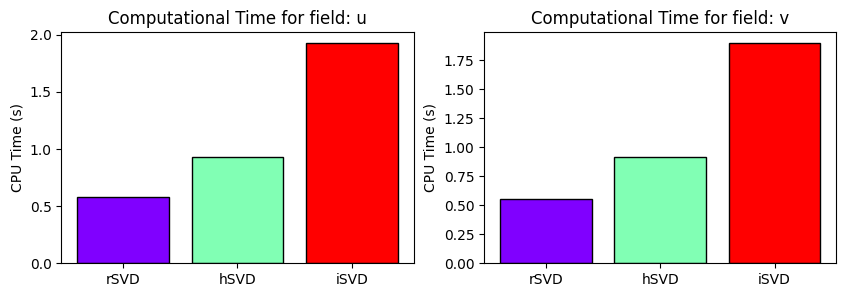

In [12]:
from matplotlib import cm

_labels = list(cpu_times.keys())

fig, axs = plt.subplots(1, len(var_names), figsize=(5*len(var_names), 3))

for field_i, field in enumerate(var_names):
    _colors = cm.rainbow(np.linspace(0, 1, len(_labels)))
    axs[field_i].bar(_labels, [cpu_times[label][field_i] for label in _labels], color=_colors, edgecolor='k')
    axs[field_i].set_ylabel('CPU Time (s)')
    axs[field_i].set_title(f'Computational Time for field: {field}')


## SVD Modes

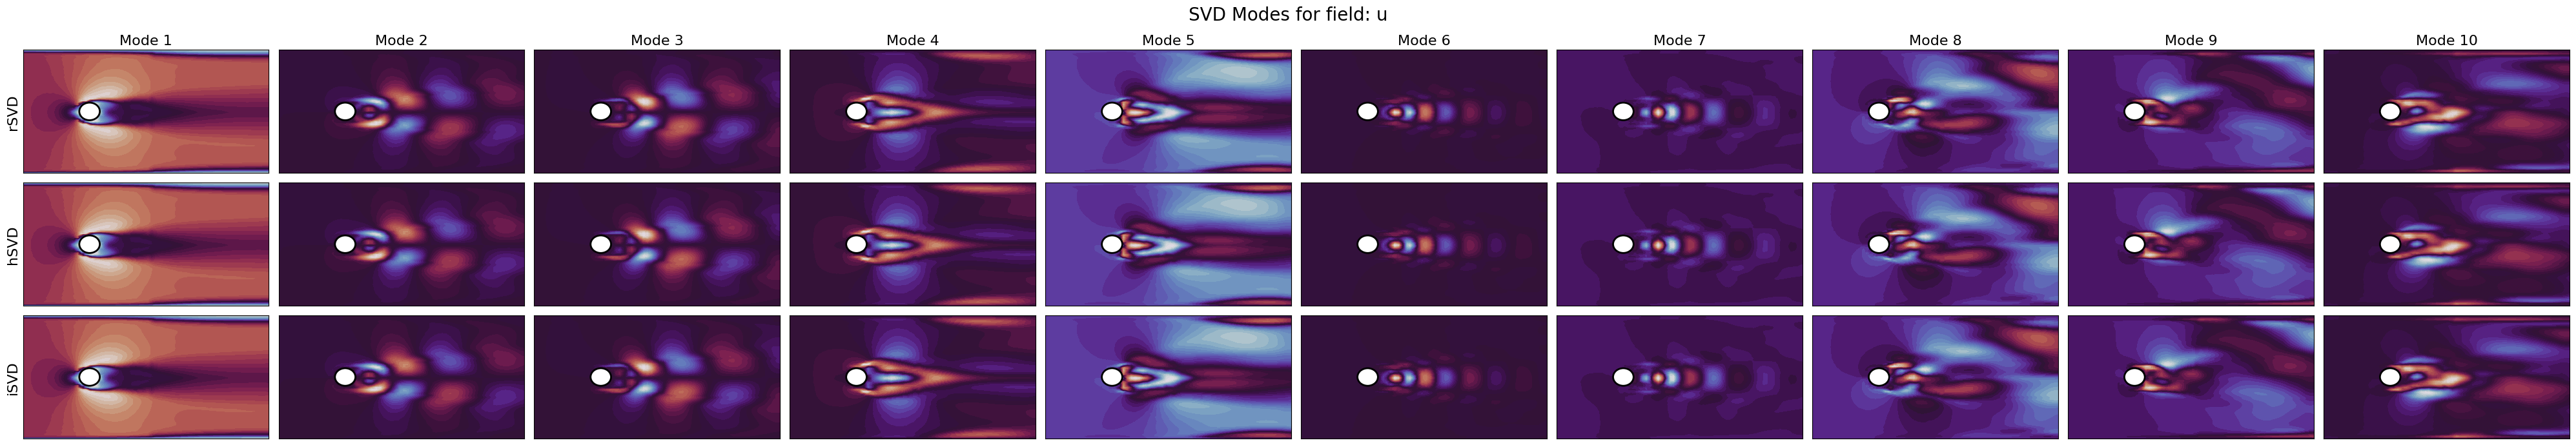

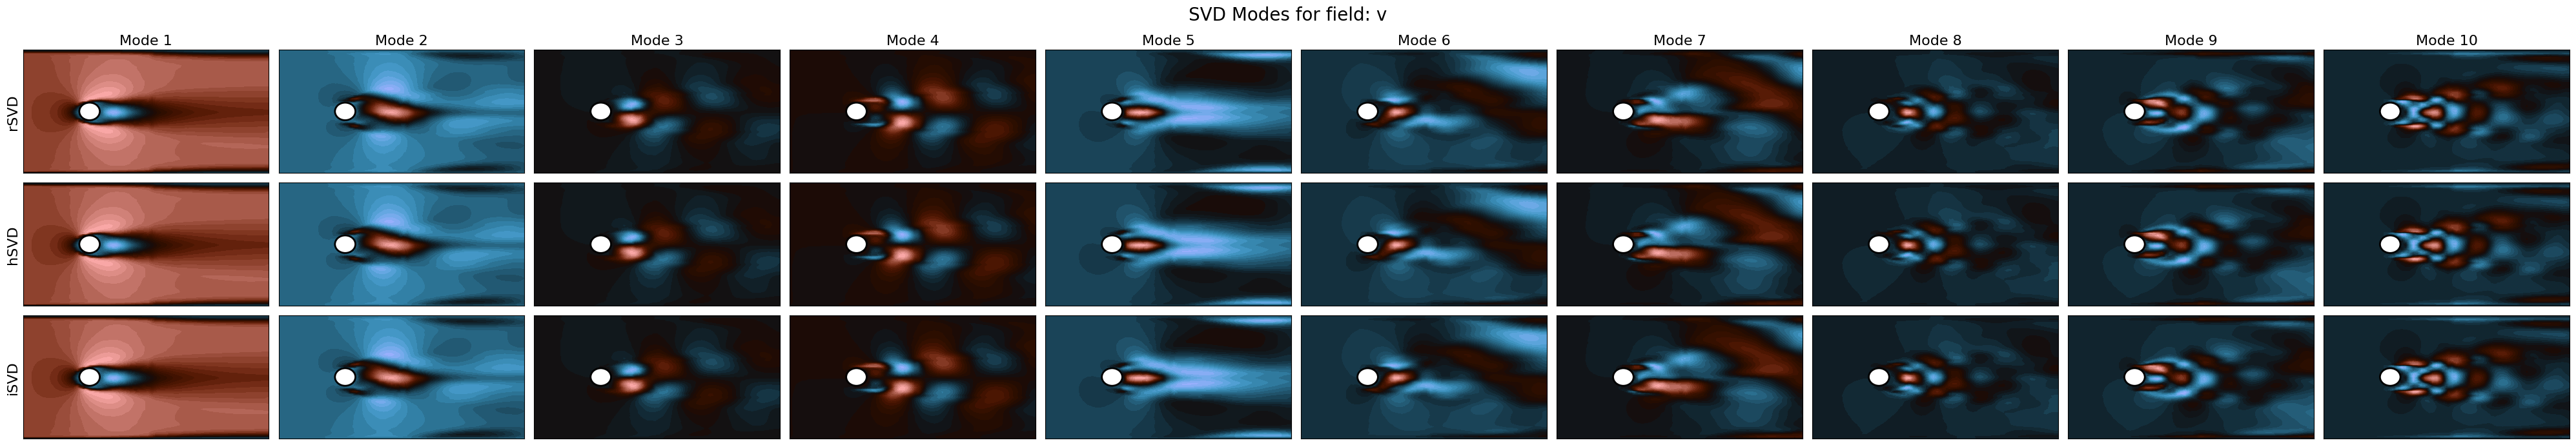

In [13]:
from matplotlib import patches
def create_circle(ax):
    radius = 0.01
    center = ((0.06+radius/2), (0.06+radius))
    circle = patches.Ellipse(center, 2*radius, 2*radius, edgecolor='black', facecolor='white', linewidth=2)
    ax.add_patch(circle)

modes_to_plot = np.arange(0,10,1)

nrows = len(_labels)
ncols = len(modes_to_plot)

aspect = (length)/(height)

cmaps = ['twilight', 'berlin']

for field_i, field in enumerate(var_names):

    fig, axs = plt.subplots(nrows, ncols, figsize=(4*ncols, 4/aspect*nrows))

    for label_i, label in enumerate(_labels):
        if label == 'rSVD':
            pod_model = rsvd[field]
        elif label == 'hSVD':
            pod_model = hsvd[field]
        
        for mode_i, mode in enumerate(modes_to_plot):
            axs[label_i, mode_i].tricontourf(*nodes.T, pod_model.svd_modes(mode), cmap=cmaps[field_i], levels=40)

            create_circle(axs[label_i, mode_i])

            if label_i == 0:
                axs[label_i, mode_i].set_title(f'Mode {mode+1}', fontsize=16)

            if mode_i == 0:
                axs[label_i, mode_i].set_ylabel(f'{label}', fontsize=16)

            axs[label_i, mode_i].set_xticks([])
            axs[label_i, mode_i].set_yticks([])

    fig.suptitle(f'SVD Modes for field: {field}', fontsize=20)
    plt.tight_layout()


### Reconstruction Errors

Let us compute the errors with respect to the test set.

In [14]:
errors = dict()

max_rank = 50

for field in var_names:

    print(f'Computing reconstruction errors for field: {field}')

    errors[field] = list()

    _test_snaps = snapshots_np[field][test_params, ::10].reshape(-1, Nh).T

    for label in _labels:

        print(f' |---Method: {label}')

        if label == 'rSVD':
            pod_model = rsvd[field]
        elif label == 'hSVD':
            pod_model = hsvd[field]

        errors[field].append(pod_model.compute_errors(_test_snaps, Nmax=max_rank, verbose=False)[1])

Computing reconstruction errors for field: u
 |---Method: rSVD
 |---Method: hSVD
 |---Method: iSVD
Computing reconstruction errors for field: v
 |---Method: rSVD
 |---Method: hSVD
 |---Method: iSVD


Let us plot them

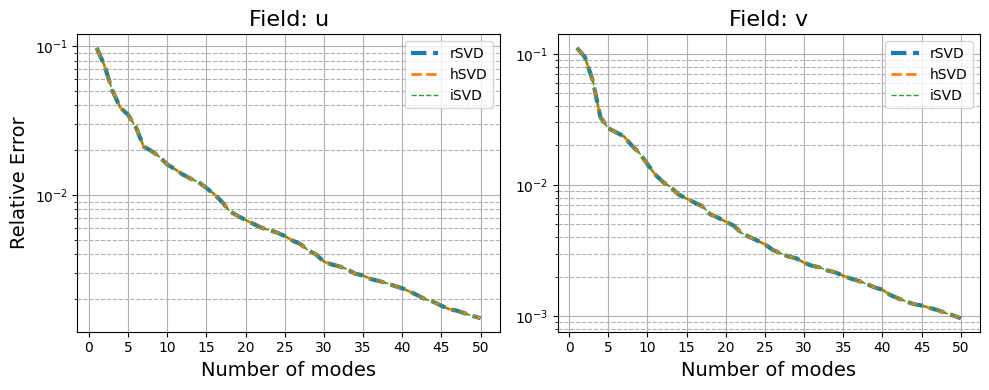

In [ ]:
fig, axs = plt.subplots(1, len(var_names), figsize=(5*len(var_names), 4))

for field_i, field in enumerate(var_names):
    
    for label_i, label in enumerate(_labels):
        axs[field_i].semilogy(np.arange(1, max_rank+1), errors[field][label_i], '--', label=label, linewidth=3-label_i)

    axs[field_i].set_xlabel('Number of modes', fontsize=14)
    if field_i == 0:
        axs[field_i].set_ylabel('Relative Error', fontsize=14)

    axs[field_i].set_title(f'Field: {field}', fontsize=16)
    axs[field_i].grid(which='major', linestyle='-')
    axs[field_i].grid(which='minor', linestyle='--')
    axs[field_i].legend()
    axs[field_i].set_xticks(np.arange(0, max_rank+1, 5))

plt.tight_layout()